# Изучение закономерностей, определяющих успешность игр

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import seaborn as sns

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод

У нас есть таблица, в которой каждая строка содержит информацию о продажах игры в разных регионах, оценках пользователей и экспертов, о жанре и платформе, а так же о годе выпуска игры. Для корректного анализа данных и выявления закономерностей, определяющих успешность игры необходимо сначала обработать таблицу: привести названия столбцов к нижнему регистру, заполнить пропуски в переменных (где большое количество пропусков), посчитать продажи игр по всему миру и изменить типы данных в перемененных (год выпуска игры и оценка пользователей).

## Предобработка данных

Приведём названия столбцов к нижнему регистру:

In [5]:
df.columns = map(str.lower, df.columns)

In [6]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Работа с пропусками

In [7]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
name,0.01
platform,0
year_of_release,1.61
genre,0.01
na_sales,0
eu_sales,0
jp_sales,0
other_sales,0
critic_score,51.32
user_score,40.09


В нескольких столбцах есть пропущенные значения, их доля особенно большая (более 40%) в переменных critic_score, user_score и rating.
Пустые значения свидетельствуют о том, что для некоторых игр доступна не вся информация. Причины могут быть разные, возможно при обработке открытых источников возникли ошибки. 
Доля пропусков в переменных name, year_of_release и genre очень мала, поэтому удалим эти строки:

In [8]:
df.dropna(subset = ['year_of_release', 'name', 'genre'], inplace = True)

Посмотрим на список уникальных значений переменных critic_score, user_score и rating:

In [9]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [10]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [11]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В значениях переменной user_score кроме nan есть ещё одно неопределённое значение - 'tbd'.
Согласно определению в Интернете: TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. Акроним служит для отметки неясностей или пропусков, которые надо заполнить, в информации требований.

Промаркируем пропуски в переменных user_score и critic_score, заменив их на '-1', чтобы в дальнейшем исключить их из анализа. Значение 'tbd'  в переменной user_score тоже заменим на '-1'. Пропуски в переменной rating заменим на строку 'unknown'. Потом убедимся, что наша таблица больше не содержит пропусков.

In [12]:
df['user_score'] = df['user_score'].fillna(-1)

In [13]:
df['user_score'] = df['user_score'].replace('tbd', -1)

In [14]:
df['critic_score'] = df['critic_score'].fillna(-1)

In [15]:
df['rating'] = df['rating'].fillna('unknown')

In [16]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
name,0
platform,0
year_of_release,0
genre,0
na_sales,0
eu_sales,0
jp_sales,0
other_sales,0
critic_score,0
user_score,0


### Изменение типов данных

Заменим типы данных в двух переменных: user_score и year_of_release. Проверим результат.

In [17]:
df['user_score'] = pd.to_numeric(df['user_score']) 

In [18]:
df['year_of_release'] = df['year_of_release'].astype('int')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null float64
user_score         16444 non-null float64
rating             16444 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


### Добавление данных в таблицу

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец:

In [20]:
df['sales_sum'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

### Вывод

В исходной таблице были обнаружены проблемы в названиях столбцов, найдены пропущенные значения в переменных name (название игры), year_of_release (год выпуска игры), genre (жанр игры), critic_score (оценка критиков), user_score (оценка пользователей) и rating (рейтинг от организации ESRB).
Мы привели к нижнему регистру названия столбцов, удалили пропуски в названиях, годах выпуска и жанрах, а в оценках критиков и пользователей заменили их на значение '-1'. В переменной user_score был обнаружено значение 'tbd', которое по сути тоже является пропуском, поэтому его тоже заменили на '-1'.
Пропущенные значения в столбце с рейтингом заменили на строку 'unknown'. Изменили типы данных: год выпуска теперь целочисленный тип, а оценки пользователей - с плавающей точкой. Посчитали суммарные продажи во всех регионах и добавили результат в таблицу.
Теперь таблица удобна для дальнейшей работы.

## Анализ

### Важны ли данные за все периоды?

Посмотрим, сколько игр выпускалось в разные годы:

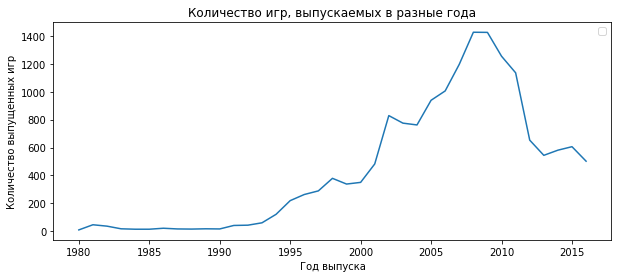

In [21]:
games_per_year = df.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.figure(figsize=(10,4))
sns.lineplot(data=games_per_year)
plt.title("Количество игр, выпускаемых в разные года")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.legend('')

Рынок компьютерных игр начал стабильно расти после 2005 года и достиг своего пика в 2008-09 годах, после чего начал снова падать. Тк продажи игр до 2005 года совсем небольшие в сравнениии с периодом после, будем пока считать, что они не важны. Рассмотрим ещё продажи по платформам, чтобы определиться с актуальным периодом годов выпуска, который будем использовать в нашем исследовании.

Найдём платформы с наибольшими суммарными продажами и посмотрим распределение по годам. 

In [22]:
platform_top = df.pivot_table(
    index='platform',
    values ='sales_sum',
    aggfunc='sum').sort_values('sales_sum', ascending=False)

In [23]:
platform_top.head(10)

,sales_sum
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Выберем топ-6 платформ с наибольшими суммарными продажами и посмотрим распределение по годам:

In [24]:
platform_top_6 = df[df['platform'].isin(('PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'))]

In [25]:
df_top_6 = platform_top_6.pivot_table(
    index=['platform', 'year_of_release'],
    values='sales_sum',
    aggfunc='sum').reset_index()

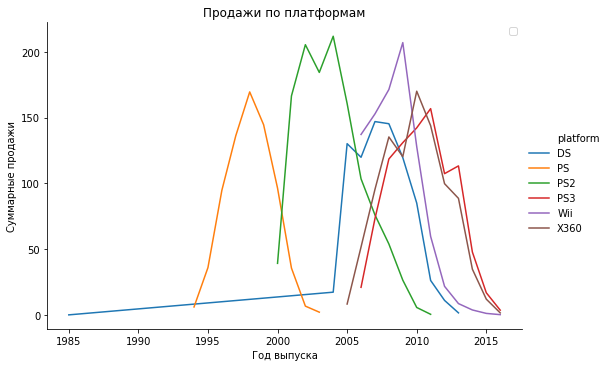

In [26]:
sns.relplot(x='year_of_release',
            y='sales_sum',
            hue='platform',
            kind='line',
            height = 5,
            aspect = 1.5,
            data=df_top_6)
plt.title("Продажи по платформам")
plt.xlabel("Год выпуска")
plt.ylabel("Суммарные продажи")
plt.legend('')

Из графика видно, что для всех представленных на графике платформ (кроме DS) есть характерный срок за которых платформа появляется, а затем исчезает - чуть более 10 лет. Пик продаж наступает примерно посередине этого периода, те через 5 лет после появления платформы. 

Посмотим на тот же график, но для всех платформ с годом выпуска после 2005:

In [27]:
df_all_platform = df[df['year_of_release'] >= 2005]

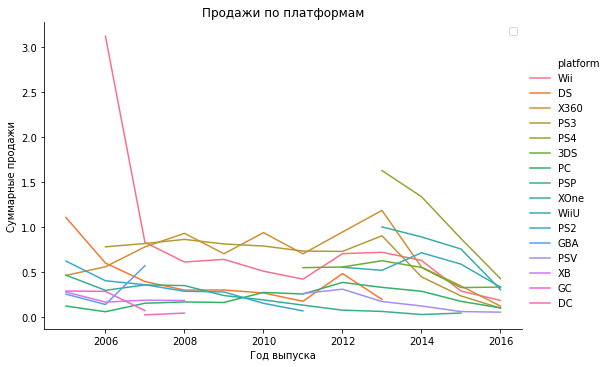

In [28]:
sns.relplot(x='year_of_release',
            y='sales_sum',
            hue='platform',
            kind='line',
            height = 5,
            aspect = 1.5,
            ci=None,
            data=df_all_platform)
plt.title("Продажи по платформам")
plt.xlabel("Год выпуска")
plt.ylabel("Суммарные продажи")
plt.legend('')

Видно, что после 2013 года появились новые платфомы, а старые либо исчезли либо имеют тенденцию к снижению продаж. Соотнеся график выше с этим возьмём в качестве актуального периода для дальнейшего анализа - с 2013 по 2016 включительно. Сохраним таблицу, с котороой дальше будем работать в переменной df_final.

In [29]:
df_final = df[df['year_of_release'] >= 2013]

### Какие платформы потенциально прибыльные?

Посмотрим для всех платформ распределение по годам уже для выбранного нами актуального периода:

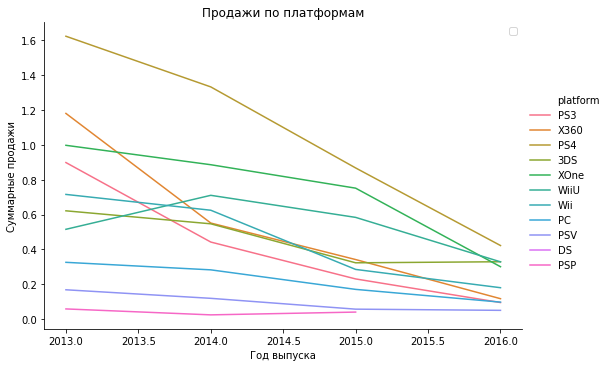

In [30]:
sns.relplot(x='year_of_release',
            y='sales_sum',
            hue='platform',
            kind='line',
            height = 5,
            aspect = 1.5,
            ci=None,
            data=df_final)
plt.title("Продажи по платформам")
plt.xlabel("Год выпуска")
plt.ylabel("Суммарные продажи")
plt.legend('')

Исходя из графика лидируют по продажам платформы PS4, XOne и WiiU. У многих платформ наблюдается падение продаж с 2013 года, кроме платформы 3DS, у которой до 2015 был спад, а потом пошёл рост и PSV, у которой с 2015 года стагнация продаж. В 2016 году самые прибыльные платформы - это PS4, 3DS, XOne и WiiU. Скорее всего они же и будут потенциально самыми прибыльными в 2017 году.
Сохраним таблицу только с этими платформами и изучим их детальнее с помощью диаграмм размаха:

In [31]:
platform_profit = df[df['platform'].isin(('PS4', '3DS', 'XOne', 'WiiU'))]

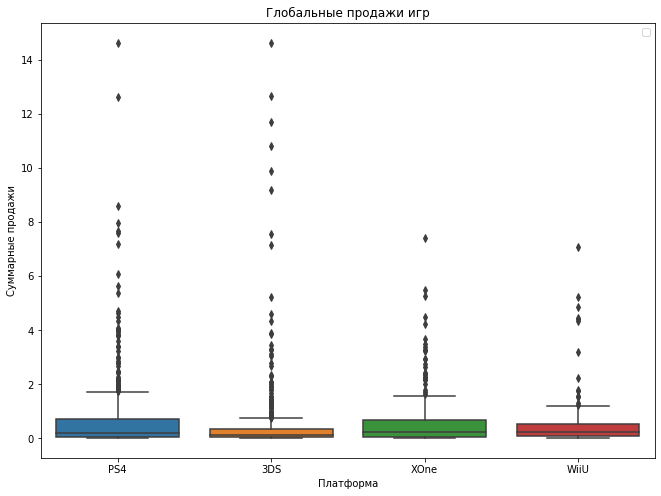

In [32]:
plt.figure(figsize=(11,8))
sns.boxplot(x='platform',
            y='sales_sum',
            data=platform_profit)
plt.title("Глобальные продажи игр")
plt.xlabel("Платформа")
plt.ylabel("Суммарные продажи")
plt.legend('')

Исходя из графиков можно сказать, что из этих четырёх платформ самые прибыльные это PS4 и XOne (у них больше медианы и много значений больше медианных). У платформ PS4 и 3DS есть много выбросных значений, которые означают, что для этих платформ есть игры, которые расходились тиражом даже 15 млн копий. У платформ 3DS и WiiU тоже есть выбросы, но максимальные значения чуть чуть не доходят до 8 млн копий.

### Как влияют на продажи отзывы пользователей и критиков?

Для анализа взаимосвязи между отзывами пользователей и критиков и продажами нам нужно сначала исключить значения, которые мы промаркировали в переменных user_score и critic_score как '-1'. Сохраним новую таблицу в переменную profit_final.

In [33]:
profit_final = platform_profit.query('(user_score != -1) and (critic_score != -1)')

Построим диаграммы рассеяния сразу для всех потенциально прибыльных платформ. Сначала посмотрим на взамосвязь между продажами и отзывами критиков.

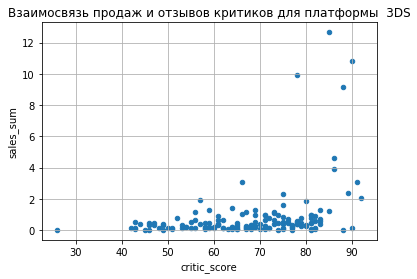

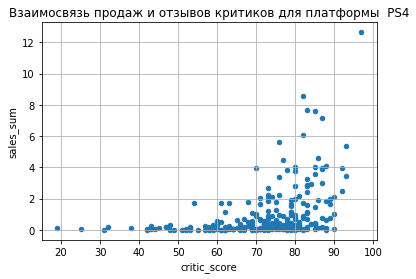

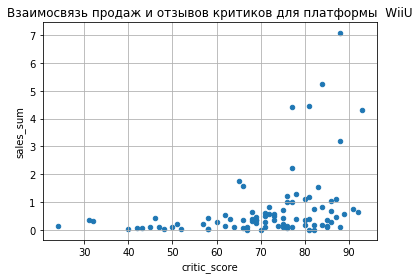

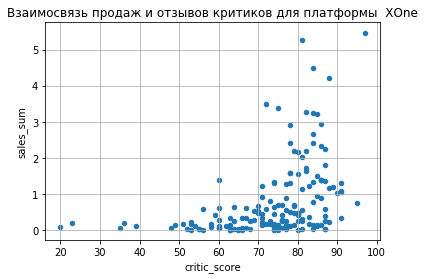

In [34]:
for name, group_data in profit_final.groupby('platform'):
    group_data.plot(x='critic_score', y='sales_sum', title='Взаимосвязь продаж и отзывов критиков для платформы  ' + name, kind='scatter', grid=True)

Из диаграмм видно, что отзывы критиков влияют на продажи для всех четырёх платформ. Больще всего эта взаимосвязь прослеживается для платформы PS4.

Теперь с помощью диаграмм рассеяния посмотрим на взаимосвязь продаж и отзывов пользователей:

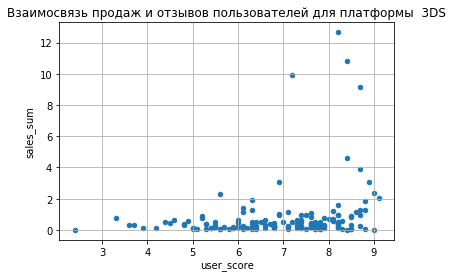

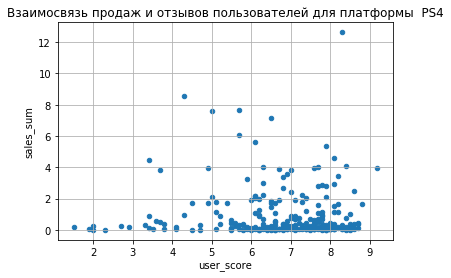

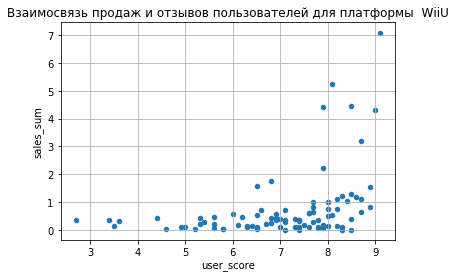

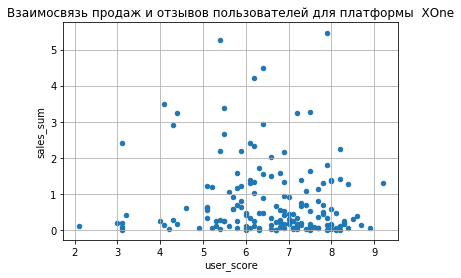

In [35]:
for name, group_data in profit_final.groupby('platform'):
    group_data.plot(x='user_score', y='sales_sum', title='Взаимосвязь продаж и отзывов пользователей для платформы  ' + name, kind='scatter', grid=True)

Здесь взаимосвязь практически не наблюдается. Только у платформы WiiU возможно есть небольшое влияние отзывов пользователей на продажи. Похоже, что оценки пользователей не взияют на продажи игр. Посчитаем коэффициенты корреляции с помощью функции.

In [36]:
def corr(platform):
    print(str(platform)+':')
    df = profit_final.query('platform == @platform')
    for column in ['user_score', 'critic_score']:
        print('Корреляция между', column, 'и sales_sum ' '{:.3f}'.format(df[column].corr(df['sales_sum'])))

In [37]:
platforms_profit = ['PS4', '3DS', 'XOne', 'WiiU']

In [38]:
for platforms in platforms_profit:
    corr(platforms)

PS4:
Корреляция между user_score и sales_sum -0.034
Корреляция между critic_score и sales_sum 0.406
3DS:
Корреляция между user_score и sales_sum 0.232
Корреляция между critic_score и sales_sum 0.339
XOne:
Корреляция между user_score и sales_sum -0.094
Корреляция между critic_score и sales_sum 0.410
WiiU:
Корреляция между user_score и sales_sum 0.392
Корреляция между critic_score и sales_sum 0.351


Корреляция между оценками пользователей и продажами очень слабая, либо отсутствует вовсе для всех платформ, кроме WiiU. Для WiiU корреляция 0,39 говорит о наличии связи, однако не сильной.
Корреляция между оценками критиков и продажами для всех исследуемых платформ выше 0.3, а для PS4 и XOne 0.4, что говорит о наличии взаимосвязи, однако не сильной.


### Какие жанры самые прибыльные?

Вернёмся к нашей таблице, в которой присутствуют продажи для всех платформ за выбранный нами актуальный период. Построим свобдную таблицу по жанрам и продажами каждого жанра.

In [76]:
genre_pivot = df_final.pivot_table(
    index=['genre'],
    values='sales_sum',
    aggfunc=('count','sum')).reset_index().sort_values('sum', ascending=False)

In [77]:
genre_pivot

,genre,count,sum
0,Action,766,321.87
8,Shooter,187,232.98
10,Sports,214,150.65
7,Role-Playing,292,145.89
3,Misc,155,62.82
4,Platform,74,42.63
6,Racing,85,39.89
2,Fighting,80,35.31
1,Adventure,245,23.64
9,Simulation,62,21.76


Топ-4 продаваемых жанров - Action, Shooter, Sports, Role-Playing. Продажи остальных жанров отличаются более чем в 2 раза от лидеров.

### Вывод

В исходной таблице были данные о продажах игр, которые выпускались с 1980 по 2016 год. Мы изучили сколько игр выпускалось и как менялись продажи по платформам и поняли, что для выявления закономерностей нам важны данные об играх, выпускаемых с 2013 по 2016 год. Самые популярные платформы, а значит и потенциально прибыльные в 2017 году - это PS4, 3DS, XOne и WiiU. У платформ PS4 и 3DS есть игры, которые расходились тиражом даже 15 млн копий. У платформ 3DS и WiiU максимальные продажи игры доходили примерно до 8 млн копий. Для всех популярных платформ отзывы критиков оказывают влияние на продажи, однако не слишком сильное.
Отзывы пользователей либо вообще не оказывают влияние на продажи, либо оно очень и очень маленькое. Топ-4 продаваемых жанров - Action, Shooter, Sports, Role-Playing. Самые невостребованные жанры - Simulation, Strategy, Puzzle. Продажи игр в этих жанрах в десятки раз меньше, чем самых популярных.

## Портрет пользователя каждого региона

### Какие платформы самые популярные в Северной Америке, Европе и Японии?

С помощью сводной таблицы и расчёта доли рынка посмотрим, какие платформы самые популярные в Северной Америке:

In [41]:
na_pivot = df_final.pivot_table(
    index=['platform'],
    values=('na_sales'),
    aggfunc='sum')

In [42]:
na_pivot['percent'] = na_pivot['na_sales'] / na_pivot['na_sales'].sum()

In [43]:
na_pivot.sort_values('na_sales', ascending = False).head()

,na_sales,percent
platform,,
PS4,108.74,0.248429
XOne,93.12,0.212744
X360,81.66,0.186562
PS3,63.50,0.145073
3DS,38.20,0.087272


Топ-5 популярных платформ в Северной Америке - PS4, XOne, X360, PS3, 3DS 

Тоже самое проделаем для Европы:

In [44]:
eu_pivot = df_final.pivot_table(
    index=['platform'],
    values=('eu_sales'),
    aggfunc='sum')

In [45]:
eu_pivot['percent'] = eu_pivot['eu_sales'] / eu_pivot['eu_sales'].sum()

In [46]:
eu_pivot.sort_values('eu_sales', ascending = False).head()

,eu_sales,percent
platform,,
PS4,141.09,0.359712
PS3,67.81,0.172883
XOne,51.59,0.131530
X360,42.52,0.108406
3DS,30.96,0.078933


Топ-5 популярных платформ в Европе - PS4, PS3, XOne, X360, 3DS.

In [47]:
jp_pivot = df_final.pivot_table(
    index=['platform'],
    values=('jp_sales'),
    aggfunc='sum')

И для Японии:

In [48]:
jp_pivot['percent'] = jp_pivot['jp_sales'] / jp_pivot['jp_sales'].sum()

In [49]:
jp_pivot.sort_values('jp_sales', ascending = False).head()

,jp_sales,percent
platform,,
3DS,67.81,0.481674
PS3,23.35,0.165862
PSV,18.59,0.132050
PS4,15.96,0.113368
WiiU,10.88,0.077284


Топ-5 популярных платформ в Японии - 3DS, PS3, PSV, PS4, WiiU. PS4 в Японии не на первом месте, как в другиз регионах. Здесь лидирует 3DS. 

PS4 имеет самую большую долю рынка в Европе (36%), XOne - в Северной Америке (21%) и не находится в топе в Японии вообще, X360 - в Северной Америке (19%), а Японии не находится в топе вообще, PS3 в Европе (17%) и Японии похожая доля рынка (16,5%), 3DS в Японии (48%).

### Какие жанры самые популярные в Северной Америке, Европе и Японии?

Посмотрим, какие жанры самые популярные в разных регионах.

In [50]:
df_final.pivot_table(
    index=['genre'],
    values='na_sales',
    aggfunc='sum').sort_values('na_sales', ascending = False).head()

,na_sales
genre,
Action,126.05
Shooter,109.74
Sports,65.27
Role-Playing,46.40
Misc,27.49


In [51]:
df_final.pivot_table(
    index=['genre'],
    values='eu_sales',
    aggfunc='sum').sort_values('eu_sales', ascending = False).head()

,eu_sales
genre,
Action,118.13
Shooter,87.86
Sports,60.52
Role-Playing,36.97
Racing,20.19


In [52]:
df_final.pivot_table(
    index=['genre'],
    values='jp_sales',
    aggfunc='sum').sort_values('jp_sales', ascending = False).head()

,jp_sales
genre,
Role-Playing,51.04
Action,40.49
Misc,9.20
Fighting,7.65
Shooter,6.61


В Северной Америке и Европе в топе почти одни и теже жанры, только в Северной Америке предпочитают Misc, а в Европе Racing.
В Японии лидирует Role-Playing, а ещё в списке лидеров есть Fighting, которого нет в топе в других двух регионах.

### Влияет ли рейтинг ESRB на продажи?

In [53]:
df_final.pivot_table(
    index=['rating'],
    values='na_sales',
    aggfunc='sum').sort_values('na_sales', ascending = False).head()

,na_sales
rating,
M,165.21
unknown,89.42
E,79.05
E10+,54.24
T,49.79


In [54]:
df_final.pivot_table(
    index=['rating'],
    values='eu_sales',
    aggfunc='sum').sort_values('eu_sales', ascending = False).head()

,eu_sales
rating,
M,145.32
E,83.36
unknown,78.91
E10+,42.69
T,41.95


In [55]:
df_final.pivot_table(
    index=['rating'],
    values='jp_sales',
    aggfunc='sum').sort_values('jp_sales', ascending = False).head()

,jp_sales
rating,
unknown,85.05
T,20.59
E,15.14
M,14.11
E10+,5.89


Согласно Википедии буквы означают: 
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. 
- «E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет и старше; 
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»:
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше.

В Северной Америке и Европе лидируют по продажам игры с рейтингом ESRB - «M» («Mature») — «Для взрослых». Далее идут в одинаковом порядке «E» («Everyone») — «Для всех», «E10+» («Everyone 10 and older»), «T» («Teen») — «Подросткам».<br>
А в Японии рейтинг ESRB влияет на продажи по другому: на первом месте по продажам игры «T» («Teen») — «Подросткам», потом «E» («Everyone») — «Для всех», «M» («Mature») — «Для взрослых» и на последнем месте «E10+» («Everyone 10 and older»).
Похоже, что в Японии в компьютерные игры больше играют подростки, а в Северной Америке и Европе - взрослые.

### Вывод

## Проверка гипотез

**Нулевая гипотеза H₀:**<br>
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**Альтернативная гипотеза H₁:**<br>
Средние пользовательские рейтинги платформ Xbox One и PC различаются

In [56]:
final_XOne = df_final.query(
    '(platform == "XOne") and (user_score != -1) and (critic_score != -1)')

In [57]:
final_PC = df_final.query(
    '(platform == "PC") and (user_score != -1) and (critic_score != -1)')

In [58]:
final_XOne['user_score'].var(ddof=1)

1.79639911308204

In [59]:
final_PC['user_score'].var(ddof=1)

2.932444842801986

In [60]:
sample_1 = final_XOne['user_score']
sample_2 = final_PC['user_score']
alpha = 0.05
results = st.ttest_ind(sample_1, sample_2, equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.17882648263401307
Не получилось отвергнуть нулевую гипотезу


In [61]:
final_XOne['user_score'].mean()

6.538181818181818

In [62]:
final_PC['user_score'].mean()

6.3020270270270276

Тест показал, что нулевую гипотезу отвергнуть не получилось, средние пользовательские рейтинги платформ Xbox One и PC не различаются. Другими словами с вероятностью в 18% различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними рейтингами.

**Нулевая гипотеза H₀:**<br>
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.

**Альтернативная гипотеза H₁:**<br>
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [63]:
final_Action = df_final.query(
    '(genre == "Action") and (user_score != -1) and (critic_score != -1)')

In [64]:
final_Sports = df_final.query(
    '(genre == "Sports") and (user_score != -1) and (critic_score != -1)')

In [65]:
final_Action['user_score'].var(ddof=1)

1.6462144328163746

In [66]:
final_Sports['user_score'].var(ddof=1)

2.1316396997497913

In [67]:
array_1 = final_Action['user_score']
array_2 = final_Sports['user_score']
alpha = 0.05
results = st.ttest_ind(array_1, array_2, equal_var = False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.0496920005008588e-13
Отвергаем нулевую гипотезу


Посчитаем средние значения пользовательских рейтингов для обоих жанров, чтобы посмотреть, у какого жанра они выше.

In [68]:
final_Action['user_score'].mean()

6.9362459546925574

In [69]:
final_Sports['user_score'].mean()

5.665454545454545

Получается, что мы отвергаем гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports  и принимаем альтернативную гипотезу - средних пользовательских рейтингов этих жанров различаются.
Мы приняли alpha = 0.05 (общепринятое пороговое значение), что означает, что мы признаём 5%-ю вероятность слишком малой и на этом основании отвергаем нулевую гипотезу.

## Вывод

Характерный срок жизни платформы примерно 10 лет, а пик продаж самых прибыльных платформ за весь период, который был в нашем распоряжении (1980-2016) был примерно посередине этого десятилетнего периода. Поэтому мы оставили для анализа только данные об играх, выпускаемых с 2013 по 2016 год, тк посчитали, что именно они помогут построить прогноз на 2017 год.<br>
В 2016 году самые прибыльные платформы - это PS4, 3DS, XOne и WiiU. Скорее всего они же и будут потенциально самыми прибыльными в 2017 году. У платформ PS4 и 3DS есть игры, которые расходились тиражом даже 15 млн копий. У платформ 3DS и WiiU максимальные продажи игры доходили примерно до 8 млн копий.<br>
Для всех популярных платформ отзывы критиков оказывают влияние на продажи, однако не слишком сильное. Отзывы пользователей либо вообще не оказывают влияние на продажи, либо оно очень и очень слабое.<br>
Топ-4 продаваемых жанров - Action, Shooter, Sports, Role-Playing. Самые невостребованные жанры - Simulation, Strategy, Puzzle. Продажи игр в этих жанрах в десятки раз меньше, чем самых популярных.<br>
Топ-5 популярных платформ в Северной Америке - PS4, XOne, X360, PS3, 3DS. Доли рынка 25%/21%/19%/14%/9%.<br>
Топ-5 популярных платформ в Европе - PS4, PS3, XOne, X360, 3DS. Доли рынка 36%/17%/13%/11%/8%.<br>
Топ-5 популярных платформ в Японии - 3DS, PS3, PSV, PS4, WiiU. Доли рынка 48%/17%/13%/11%/8%.<br>
В Северной Америке и Европе в топе почти одни и теже жанры: Action, Shooter, Sports, Role-Playing. Только последнее место в топ-5 в Северной Америке занимает Misc, а в Европе Racing. В Японии лидирует Role-Playing, а ещё в списке лидеров есть Fighting, которого нет в топе в других двух регионах.<br>
В Северной Америке и Европе лидируют по продажам игры с рейтингом ESRB - «M» («Mature») — «Для взрослых». А в Японии рейтинг ESRB влияет на продажи по другому: на первом месте по продажам игры «T» («Teen») — «Подросткам». Похоже, что в Японии в компьютерные игры больше играют подростки, а в Северной Америке и Европе - взрослые.<br>
Средние пользовательские рейтинги платформ Xbox One и PC не различаются. Средние пользовательские рейтинги жанров Action и Sports разные.